In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import lu # compute LU decomposition
from scipy.optimize import minimize # minimization of scalar function

# 1. Generate location data $X$

In [3]:
# function that makes coordincates of data points
def make_coords(N_points, xmu, xsd, ymu, ysd):  
    x_coords = np.random.normal(xmu, xsd, size=N_points)
    y_coords = np.random.normal(ymu, ysd, size=N_points)
    coords = np.column_stack((x_coords, y_coords))
    return coords

* 수정) For문보다 효율적으로 Distance 구하는 방법 찾아보기

In [4]:
# function that calculates distances between coordinates
def distances(coords):
    N = len(coords)
        
    # Initialize an empty distances matrix
    distances = np.zeros((N, N))

    # Compute the euclidean distance between pair of coords
    for i in range(N):
        for j in range(i+1, N):
            distances[i,j] = distances[j,i] = np.linalg.norm(coords[i] - coords[j])       

    return distances

In [5]:
np.random.seed(24)

In [6]:
# set parameters
p = 10 # dimensionaltiy

In [7]:
# get coordinates
coord = [0, 1, 0, 1] # xmu, xsd, ymu, ysd
X = make_coords(p, *coord)
X

array([[ 1.32921217,  0.6788048 ],
       [-0.77003345,  1.88927273],
       [-0.31628036,  0.9615384 ],
       [-0.99081039,  0.1040112 ],
       [-1.07081626, -0.48116532],
       [-1.43871328,  0.85022853],
       [ 0.56441685,  1.45342467],
       [ 0.29572189,  1.05773744],
       [-1.62640423,  0.16556161],
       [ 0.2195652 ,  0.51501838]])

In [8]:
# get distances
d = distances(X)

# 2. Covariance Matrix $\Sigma$
$$ \Sigma = Cov(Y_i, Y_j|X) = \theta_1 \exp(-\frac{1}{\theta_2} d_{ij}) \\ d_{ij} = ||X_i - X_j||$$

In [9]:
# function that makes covariance matrix Sigma
def Sigma(param, dis):
  theta1, theta2 = param[0], param[1]
  cov = theta1*np.exp((-1/theta2)*dis) # distance matrix is a square matrix
  return cov

In [10]:
# get SigmaTrue
paramTrue = [1, 1/2] 
SigmaTrue = Sigma(paramTrue, d)

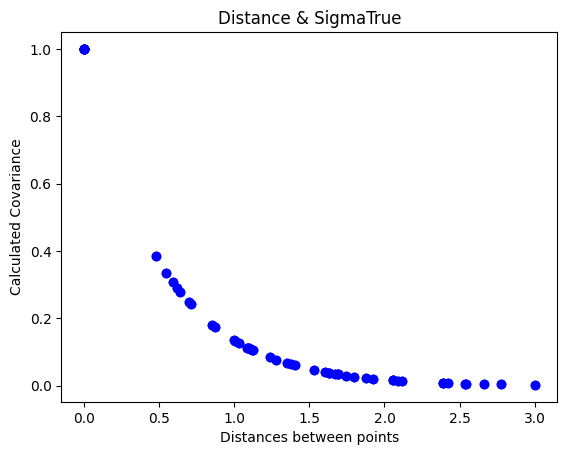

In [33]:
# plotting
d_plot = d.reshape((p*p,))
Sigma_plot = SigmaTrue.reshape((p*p,))
data = pd.DataFrame({'Distances': d_plot, 'Calculated Covariance': Sigma_plot})

plt.scatter(data['Distances'], data['Calculated Covariance'], c='blue')
plt.ylabel('Calculated Covariance')
plt.xlabel('Distances between points')
plt.title('Distance & SigmaTrue')
plt.show()

# 3. Generate data $Y$
$ Y = \Sigma^{1/2} \cdot U $ 
* $\Sigma$ is positive semi definite 
* $U \sim N(0, I_p)$


Thus, $Y \sim N(0, \Sigma) $

cf. Getting $\Sigma^{1/2}$
* Choleskey factorization
    * Conditions: 1) Positive Definite, 2) Square, 3) Symmetric (No need to check condition 2 & 3 as Sigma is covariance matrix)



In [35]:
# check if SigmaTrue is positive definite
## cf. pd <-> all eigenvalues > 0
pd = np.linalg.eig(SigmaTrue)[0].min() > 0
if pd:
    SigmaHalf = np.linalg.cholesky(SigmaTrue) 
    print('Covariance matrix is positive definite')
else: 
    print('Covariance matrix is not positive definite')

Covariance matrix is positive definite


In [37]:
# generate y
U = np.random.normal(0, 1, p).reshape(p, 1)
Y = np.dot(SigmaHalf, U)
Y.shape # check the dimensionality of Y

(10, 1)

# 4. Parameter Estimation

$$ logL(\vec{\theta};\vec{Y}) = -\frac{1}{2} \log ( |\Sigma(\theta)|) - \frac{1}{2} \vec{Y}^T (\Sigma(\theta))^{-1} \vec{Y} $$

1. $\log ( |\Sigma(\theta)|$
* Using the mathematical fact that the determinant of a triangular matrix equals the product of its diagonal elements, we use matrix factorization to get determinants to prevent over/underflow issue (that occurs when trying to calculate the determinant of large matrices) in this case.

* Check if the matrix is positive definite or not.
    * 1-1) If the matrix is positive definite: use choleskey factorization
    * 1-2) Is the matrix is not positive definite: use LU factorization

2. $\Sigma(\theta))^{-1}$
* Check if the matrix is invertible or not.

In [27]:
# check pd
def check_pd(Sigma):
    if np.linalg.eig(Sigma)[0].min() > 0:
        return True
    else:
        return False

In [28]:
# check invertible
def check_invertible(matrix):
    try:
        inverse = np.linalg.inv(matrix)
        return True
    except np.linalg.LinAlgError:
        return False

## 4-1. Likelihood function

In [29]:
# define log likelihood function
def logLikelihood(param, Y):
    
    p = len(Y)
    sig = Sigma(param, d)
    chol = check_pd(sig) 
    inv = check_invertible(sig)
    
    if chol: 
        # choleskey factorization
        log_det_Sigma = 2 * np.sum(np.log(np.diag(np.linalg.cholesky(sig))))
    else: 
        # LU factorization
        P, L, U = lu(sig)
        du = np.diag(U)
        c = np.linalg.det(P) * np.prod(np.sign(du))
        log_det_Sigma = np.log(c) + np.sum(np.log(np.abs(du)))

    
    if inv:
        inv_Sigma = np.linalg.inv(sig)
    else:   
        inv_Sigma = np.linalg.pinv(sig) # pseudo inverse
    
        
    return 0.5 * Y.T @ inv_Sigma @ Y + 0.5 * log_det_Sigma

## 4-2. MLE

In [31]:
param0 = paramTrue

                
# Define the optimization problem
problem = {
    'fun': logLikelihood,         # Objective function: minimize the minimum eigenvalue
    'x0': paramTrue,            # Initial guess for the parameters
    'args': (Y,),             # Additional arguments for the objective function 
    'method': 'BFGS'        
}

result = minimize(**problem)

estimated_params = result.x

In [32]:
print("MLE = ", estimated_params)

array([1.03933337, 0.8866519 ])